Importing Libs

In [1]:
import tensorflow as tf # for deep learning
from tensorflow import keras # for deep learning
from tensorflow.keras import backend as K # for deep learning
from tensorflow.keras.layers import Dense,Dropout # for deep learning
from tensorflow.keras.optimizers.legacy import  Adamax # for deep learning
from tensorflow.keras import regularizers # for deep learning
from tensorflow.keras.preprocessing.image import ImageDataGenerator # for deep learning
from tensorflow.keras.models import Model, load_model # for deep learning
import numpy as np # for data manipulation
import pandas as pd # for data manipulation
import time # for timing
import cv2 as cv2 # for image manipulation
from sklearn.model_selection import train_test_split # for data splitting
import matplotlib.pyplot as plt # for plotting 
from matplotlib.pyplot import imshow # for plotting
import os # for file manipulation
import seaborn as sns # for plotting (heatmap)
sns.set_style('darkgrid')
from sklearn.metrics import confusion_matrix, classification_report # for model evaluation


### Supporting Functions

Function to show sample of images

In [2]:
def show_image_samples(generator):
    """Show a sample of images from a generator

    Args:
        gen: a generator object
    """
    t_dict=generator.class_indices
    classes=list(t_dict.keys())    
    images,labels=next(generator) # get a sample batch from the generator 
    plt.figure(figsize=(20, 20))
    length=len(labels)
    if length<15:   #show maximum of 15 images
        r=length
    else:
        r=25
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]/255
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=classes[index]
        plt.title(class_name, color='black', fontsize=16)
        plt.axis('off')
    plt.show()

Keras Callback Class

In [3]:
class Callback(keras.callbacks.Callback):
    
    def __init__(self,model, patience,stop_patience, threshold, factor, rollback, batches, initial_epoch,epochs, ask_epoch):
        """Callback class to adjust learning rate based on training and validation accuracy and loss

        Args:
            model: model object
            patience: specifies how many epochs without improvement before learning rate is adjusted
            stop_patience: specifies how many times to adjust lr without improvement to stop training
            threshold: specifies training accuracy threshold when lr will be adjusted based on validation loss
            factor: factor by which to reduce the learning rate
            rollback: number of epochs to rollback at the new learning rate
            batches: number of training batches to run per epoch
            initial_epoch: initial epoch number
            epochs: number of epochs to train
            ask_epoch: epoch number to ask if training should continue
        """
        super(Callback, self).__init__()
        self.model=model
        self.patience=patience
        self.stop_patience=stop_patience 
        self.threshold=threshold 
        self.factor=factor 
        self.rollback=rollback
        self.batches=batches
        self.initial_epoch=initial_epoch
        self.epochs=epochs
        self.ask_epoch=ask_epoch
        self.ask_epoch_initial=ask_epoch 
        
        
        # callback variables 
        self.count=0 # counter for how many times lr has been reduced without improvement
        self.stop_count=0        
        self.best_epoch=1   # initialize epoch with the lowest loss        
        self.initial_lr=float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it 
        self.highest_tracc=0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss=np.inf # set lowest validation loss to infinity initially
        self.best_weights=self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights=self.model.get_weights()   # save initial weights if they have to get restored 
        
    def on_train_begin(self, logs=None):
        """Called at the start of training.
        
        """
        msg='initialing callback and starting training'                        
        print(msg) 
        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
        print(msg) 
        self.start_time= time.time()
        
    def on_train_end(self, logs=None):
        """Called at the end of training.
        
        """
        stop_time=time.time()
        tr_duration= stop_time- self.start_time            
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        self.model.set_weights(self.best_weights) # set the weights of the model to the best weights
        msg=f'Training is completed - model is set with weights from epoch {self.best_epoch} '
        print(msg)
        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)   
        
    def on_train_batch_end(self, batch, logs=None):
        """Called at the end of a training batch.

        Args:
            batch: batch number
            logs: dictionary of logs
        """
        acc=logs.get('accuracy')* 100  # get training accuracy 
        loss=logs.get('loss')
        msg='{0:20s}processing batch {1:4s} of {2:5s} accuracy= {3:8.3f}  loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end='') # prints over on the same line to show running batch count        
        
    def on_epoch_begin(self,epoch, logs=None):
        """Called at the beginning of an epoch.

        Args:
            epoch: epoch number
            logs: dictionary of logs
           
        """
        self.now= time.time()
        
    def on_epoch_end(self, epoch, logs=None):
        """Called at the end of an epoch.

        Args:
            epoch: epoch number
            logs: dictionary of logs
        """
        later=time.time()
        duration=later-self.now 
        lr=float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr=lr
        v_loss=logs.get('val_loss')  # get the validation loss for this epoch
        acc=logs.get('accuracy')  # get training accuracy 
        v_acc=logs.get('val_accuracy')
        loss=logs.get('loss')        
        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor='accuracy'
            if acc>self.highest_tracc: # training accuracy improved in the epoch                
                self.highest_tracc=acc # set new highest training accuracy
                self.best_weights=self.model.get_weights() # traing accuracy improved so save the weights
                self.count=0 # set count to 0 since training accuracy improved
                self.stop_count=0 # set stop counter to 0
                if v_loss<self.lowest_vloss:
                    self.lowest_vloss=v_loss
                color= (0,255,0)
                self.best_epoch=epoch + 1  # set the value of best epoch for this epoch              
            else: 
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count>=self.patience -1: # lr should be adjusted
                    color=(245, 170, 66)
                    lr= lr* self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count=0 # reset the count to 0
                    self.stop_count=self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count=0 # reset counter
                    if self.rollback:
                        self.model.set_weights(self.best_weights) # return to better point in N space                        
                    else:
                        if v_loss<self.lowest_vloss:
                            self.lowest_vloss=v_loss                                    
                else:
                    self.count=self.count +1 # increment patience counter                    
        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor='val_loss'
            if v_loss< self.lowest_vloss: # check if the validation loss improved 
                self.lowest_vloss=v_loss # replace lowest validation loss with new validation loss                
                self.best_weights=self.model.get_weights() # validation loss improved so save the weights
                self.count=0 # reset count since validation loss improved  
                self.stop_count=0  
                color=(0,255,0)                
                self.best_epoch=epoch + 1 # set the value of the best epoch to this epoch
            else: # validation loss did not improve
                if self.count>=self.patience-1: # need to adjust lr
                    color=(245, 170, 66)
                    lr=lr * self.factor # adjust the learning rate                    
                    self.stop_count=self.stop_count + 1 # increment stop counter because lr was adjusted 
                    self.count=0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    if self.rollback:
                        self.model.set_weights(self.best_weights) # return to better point in N space
                else: 
                    self.count =self.count +1 # increment the patience counter                    
                if acc>self.highest_tracc:
                    self.highest_tracc= acc
        msg=f'{str(epoch+1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc*100:^9.3f}{v_loss:^9.5f}{v_acc*100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{duration:^8.2f}'
        print(msg)
        if self.stop_count> self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg=f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training
        else: 
            if self.ask_epoch !=None:
                if epoch + 1 >= self.ask_epoch:
                    msg='enter S to Stop training OR an integer for the number of epochs to run then ask again'
                    print(msg)
                    ans=input('')
                    if ans=='S' or ans=='s':
                        msg=f'training has been Stopped at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True # stop training
                        
                    else:
                        ans=int(ans)
                        self.ask_epoch +=ans
                        msg=f' training will continue until epoch ' + str(self.ask_epoch)                         
                        print(msg)
                        msg='{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:^8s}'.format('Epoch', 'Loss', 'Accuracy',
                                                                                              'V_loss','V_acc', 'LR', 'Next LR', 'Monitor', 'Duration')
                        print(msg) 

Function to create Training Plot

In [4]:
def training_plot(training_data, start_epoch):
    """ Plots training and validation data for accuracy and validation loss

    Args:
        training_data: training data 
        start_epoch: the epoch at which training started
    """
    #Plot the training and validation data
    tacc=training_data.history['accuracy']
    tloss=training_data.history['loss']
    vacc=training_data.history['val_accuracy']
    vloss=training_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)   
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'r', label='Training loss')
    axes[0].plot(Epochs,vloss,'g',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'r',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'g',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

Function to create Confusion Matrix / report

In [5]:
def cm_report(test_gen, predictions):
    """ Creates a confusion matrix and classification report for the test data

    Args:
        test_gen: test data generator
        predictions: predictions from the model
    """
    class_dict=test_gen.class_indices
    labels= test_gen.labels
    new_dict={}
    # error_indices=[]
    y_pred=[]
    for key,value in class_dict.items():
        new_dict[value]=key             # dictionary {integer of class number: string of class name}
    # store new_dict as a text fine in the save_dir
    classes=list(new_dict.values())     # list of string of class names     
    for p in predictions:
        pred_index=np.argmax(p)         
        # true_index=labels[i]  # labels are integer values
        y_pred.append(pred_index)    
    y_true= np.array(labels)        
    y_pred=np.array(y_pred)
    if len(classes)<= 6:
        # create a confusion matrix 
        cm = confusion_matrix(y_true, y_pred )        
        length=len(classes)
        if length<8:
            fig_width=8
            fig_height=8
        else:
            fig_width= int(length * .5)
            fig_height= int(length * .5)
        plt.figure(figsize=(fig_width, fig_height))
        sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
        plt.xticks(np.arange(length)+.5, classes, rotation= 90)
        plt.yticks(np.arange(length)+.5, classes, rotation=0)
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.title("Confusion Matrix")
        plt.show()
    clr = classification_report(y_true, y_pred, target_names=classes)
    print("Classification Report:\nــــــــــــــــــــــ\n", clr)

Save Model

In [6]:
def save(save_path, model, model_name,img_size, scalar, generator):
    # first save the model
    save_id=str (model_name + '.h5')
    model_save_loc=os.path.join(save_path, save_id)
    model.save(model_save_loc)
    print('Model saved: ' + model_save_loc) 
    # now create the class_df and convert to csv file    
    class_dict=generator.class_indices 
    height=[]
    width=[]
    scale=[]
    for i in range(len(class_dict)):
        height.append(img_size[0])
        width.append(img_size[1])
        scale.append(scalar)
    Index_series=pd.Series(list(class_dict.values()), name='class_index')
    Class_series=pd.Series(list(class_dict.keys()), name='class') 
    Height_series=pd.Series(height, name='height')
    Width_series=pd.Series(width, name='width')
    Scale_series=pd.Series(scale, name='scale by')
    class_df=pd.concat([Index_series, Class_series, Height_series, Width_series, Scale_series], axis=1)    
    csv_name='class.csv'
    csv_save_loc=os.path.join(save_path, csv_name)
    class_df.to_csv(csv_save_loc, index=False) 
    print('class csv saved: ' + csv_save_loc) 
    return model_save_loc, csv_save_loc

Load model and predict class

In [7]:
def load_predict(sdir, csv_path,  model_path):
    """Loads a trained model and then classifies images in a directory

    Args:
        sdir (dir): Drive directory containing images to classify
        csv_path (string_file_path): path to csv file containing df information
        model_path (string_file_path): path to model .h5 file

    Returns:
        model: trained model
    """
    # read in the csv file
    class_df=pd.read_csv(csv_path)    
    img_height=int(class_df['height'].iloc[0])
    img_width =int(class_df['width'].iloc[0])
    img_size=(img_height, img_width)
    scale=class_df['scale by'].iloc[0] 
    try: 
        s=int(scale)
        s2=1
        s1=0
    except:
        split=scale.split('-')
        s1=float(split[1])
        s2=float(split[0].split('*')[1]) 
        print (s1,s2)
    path_list=[]
    paths=os.listdir(sdir)
    for f in paths:
        path_list.append(os.path.join(sdir,f))
    print (' Model is being loaded- this will take about 10 seconds')
    model=load_model(model_path)
    image_count=len(path_list)    
    index_list=[] 
    prob_list=[]
    cropped_image_list=[]
    for i in range (image_count):       
        img=plt.imread(path_list[i])
        img=cv2.resize(img, img_size)
        cropped_image_list.append(img)
        img=img*s2 - s1
        img=np.expand_dims(img, axis=0)
        p= np.squeeze (model.predict(img))           
        index=np.argmax(p)
        print('Name:',os.path.basename(path_list[i]),'|','Class: ',class_df['class'].iloc[index])
        prob=p[index]
        index_list.append(index)
        prob_list.append(prob)
    return model

### Data Handeling

Import images and create dataframe

In [8]:
sdir= r'./clean NO'
classlist= os.listdir(sdir)    
filepaths= []
labels= []    
for klass in classlist:
    classpath= os.path.join(sdir,klass)        
    flist= os.listdir(classpath)        
    for f in flist:
        fpath=os.path.join(classpath,f)        
        filepaths.append(fpath)
        labels.append(klass) 
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries= pd.Series(labels, name='labels')
df=pd.concat([Fseries, Lseries], axis=1) 
train_split= .8
valid_split= .1
test_valid_split= valid_split/(1-train_split)
train_df,vt_df= train_test_split(df, train_size=train_split, shuffle=True, random_state=123)
valid_df,test_df= train_test_split(vt_df, train_size=test_valid_split, shuffle=True, random_state=123)
print('train_df size: ', len(train_df), '  test_df size: ',len(test_df), '  valid_df size: ', len(valid_df))
balance=list(train_df['labels'].value_counts())
    

train_df size:  7388   test_df size:  924   valid_df size:  924


Generators

In [9]:
#EfficientNet works best with images of size (224,224,3)
#ImageDataGenerator will tweak the images to create more data, and make sure it sees each image only once per epoch

height=224
width=224
channels=3
batch_size=40
img_shape=(height, width, channels)
img_size=(height, width)
length=len(test_df)
test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]  
test_steps=int(length/test_batch_size)
print ( 'test batch size: ' ,test_batch_size, '  test steps: ', test_steps)
def scalar(img):    
    return img  # EfficientNet expects pixels in range 0 to 255 so no scaling is required
train_gen=ImageDataGenerator(preprocessing_function=scalar, horizontal_flip=True, vertical_flip=True)
test_valid_gen=ImageDataGenerator(preprocessing_function=scalar)
train_gen=train_gen.flow_from_dataframe( train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
test_gen=test_valid_gen.flow_from_dataframe( test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=False, batch_size=test_batch_size)
valid_gen=test_valid_gen.flow_from_dataframe( valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                    color_mode='rgb', shuffle=True, batch_size=batch_size)
classes=list(train_gen.class_indices.keys())
class_count=len(classes)
train_steps=np.ceil(len(train_gen.labels)/batch_size)

test batch size:  77   test steps:  12
Found 7388 validated image filenames belonging to 6 classes.
Found 924 validated image filenames belonging to 6 classes.
Found 924 validated image filenames belonging to 6 classes.


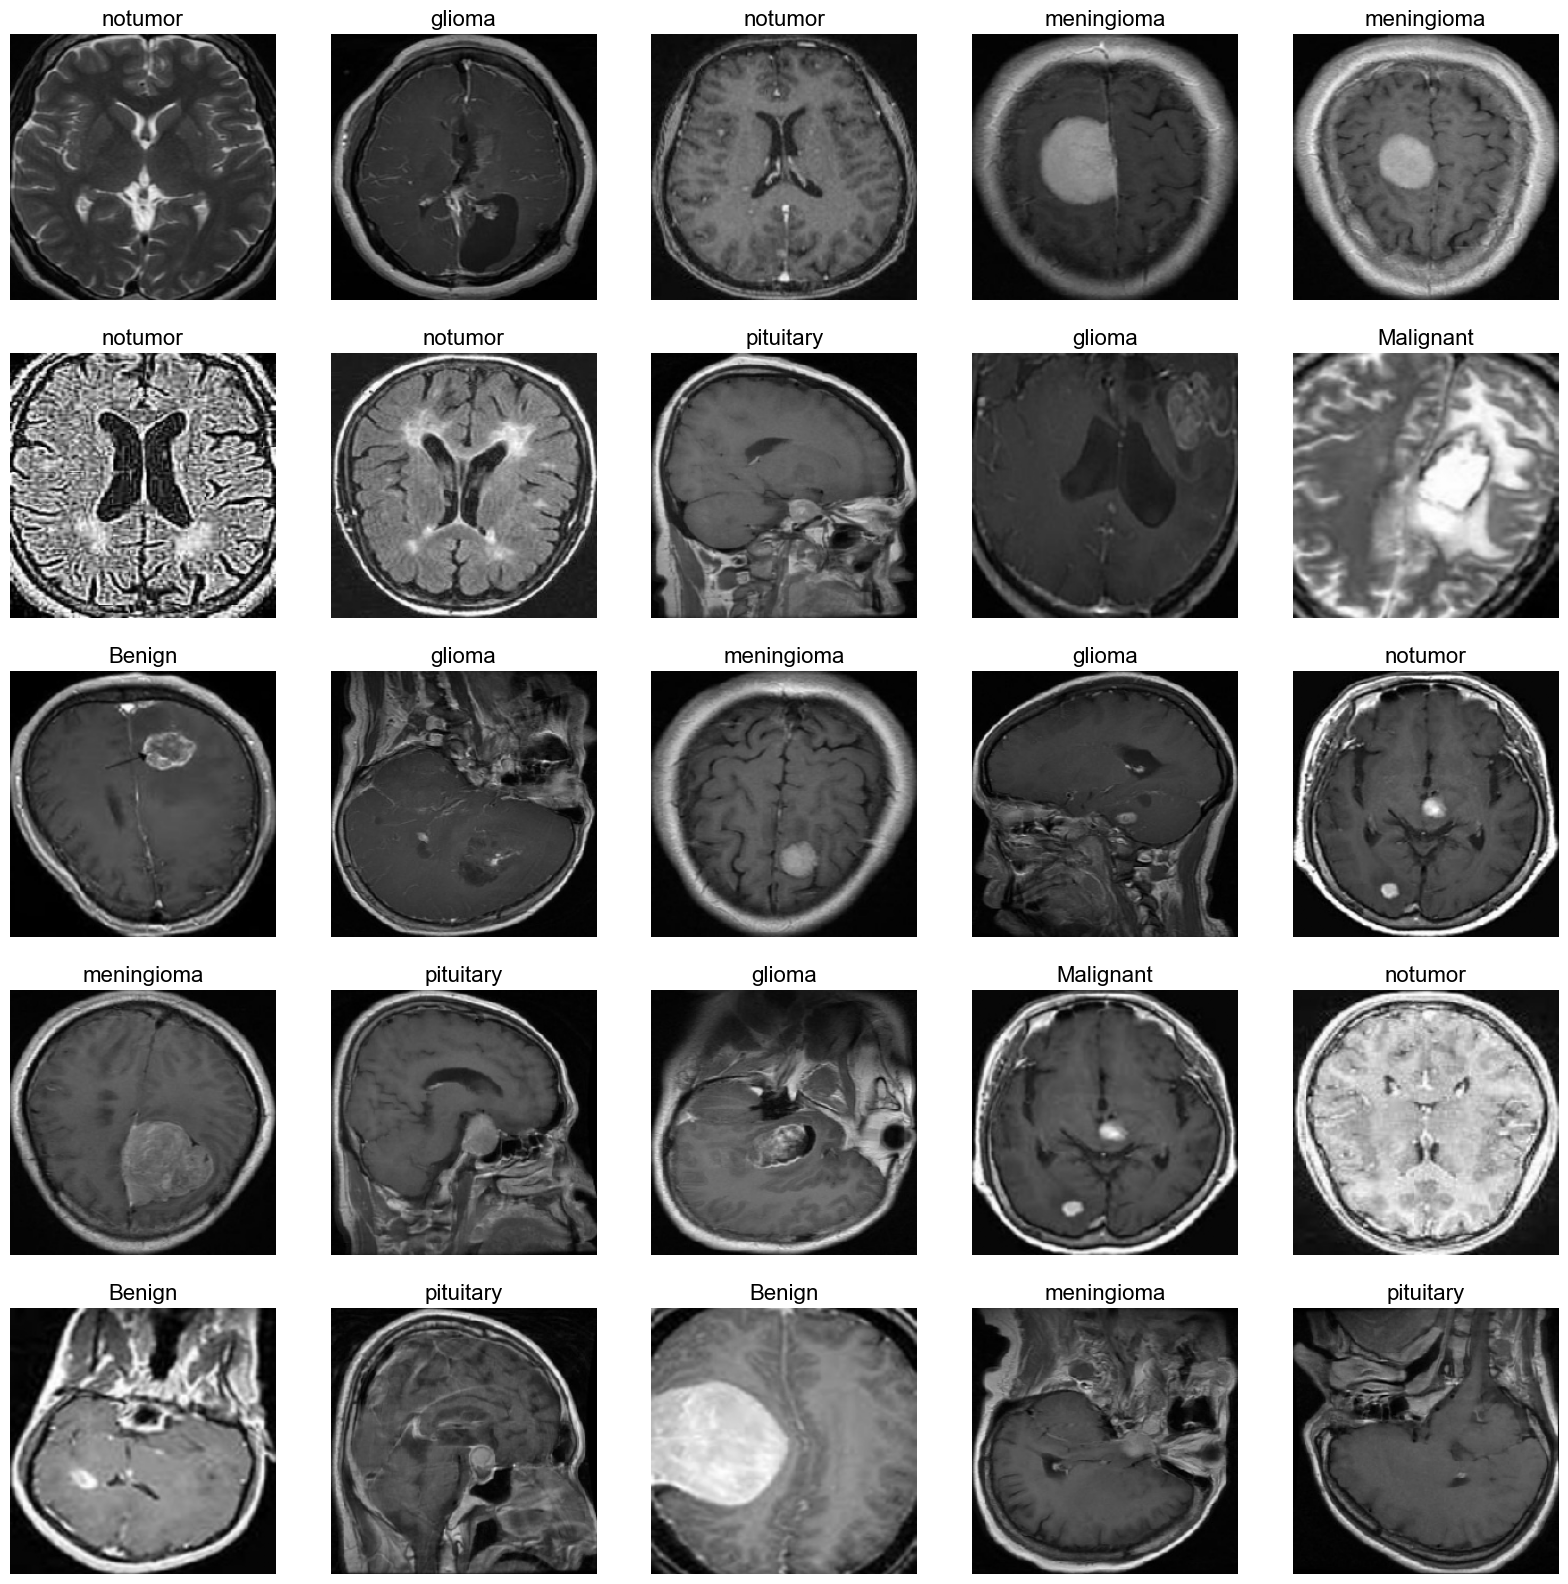

In [10]:
show_image_samples(train_gen)

### Models

Creating the models

In [11]:
model_name='EfficientNetB6'
base_model=tf.keras.applications.EfficientNetB6(include_top=False, weights="imagenet",input_shape=img_shape, pooling='max') 
x=base_model.output
x=keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
x=Dropout(rate=.45, seed=123)(x)
output=Dense(class_count, activation='softmax')(x)
model=Model(inputs=base_model.input, outputs=output)
model.compile(Adamax(learning_rate=.001), loss='categorical_crossentropy', metrics=['accuracy'])

165234480/165234480 [==============================] - 32s 0us/step


Model Training

In [ ]:
epochs = 40
patience = 1 # number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3 # number of epochs to wait before stopping training if monitored value does not improve
threshold = .9 # if train accuracy is < threshhold adjust monitor accuracy, else monitor validation loss
factor = .5 # factor to reduce lr by
rollback = True # if True and monitored metric does not improve on current epoch set model weights back to weights of previous epoch
ask_epoch = 3 # number of epochs to run before asking if you want to halt training
batches = train_steps
callbacks = [Callback(model=model,patience=patience,stop_patience=stop_patience, threshold=threshold,
                   factor=factor,rollback=rollback, batches=batches,initial_epoch=0,epochs=epochs, ask_epoch=ask_epoch )]

record = model.fit(x=train_gen,  epochs=epochs, verbose=1, callbacks=callbacks,  validation_data=valid_gen,
               validation_steps=None,  shuffle=False,  initial_epoch=0)

Model Evaluation

In [ ]:
training_plot(record,0)
save_dir='./'
acc=model.evaluate( test_gen, batch_size=test_batch_size, verbose=1, steps=test_steps, return_dict=False)[1]*100
msg=f'accuracy on the test set is {acc:5.2f} %'
print(msg)
save_id=str (model_name+'-'+ str(acc)[:str(acc).rfind('.')+3] + '.h5')
save_loc=os.path.join(save_dir, save_id)
model.save(save_loc)
generator=train_gen
scale = 1

# Save the model and the weights
result=save(save_dir, model, model_name, acc, img_size, scale,  generator)

### Predictions


Using Trained model

In [12]:
input_folder = './Input/'
df_cvs = './Models/B6/class.csv'
model_path = './Models/B6/EfficientNetB6.h5'

model = load_predict(input_folder, df_cvs, model_path)


 Model is being loaded- this will take about 10 seconds
1/1 [==============================] - 8s 8s/step
Name: be_108.jpg | Class:  Benign
1/1 [==============================] - 1s 718ms/step
Name: be_112.jpg | Class:  Benign
1/1 [==============================] - 0s 493ms/step
Name: be_13.jpg | Class:  Benign
1/1 [==============================] - 1s 579ms/step
Name: be_61.jpg | Class:  Benign
1/1 [==============================] - 1s 540ms/step
Name: gl_117.jpg | Class:  glioma
1/1 [==============================] - 0s 365ms/step
Name: gl_147.jpg | Class:  glioma
1/1 [==============================] - 1s 602ms/step
Name: gl_72.jpg | Class:  glioma
1/1 [==============================] - 1s 551ms/step
Name: gl_76.jpg | Class:  glioma
1/1 [==============================] - 0s 414ms/step
Name: ma_122.jpg | Class:  Malignant
1/1 [==============================] - 1s 541ms/step
Name: ma_173.jpg | Class:  Malignant
1/1 [==============================] - 0s 367ms/step
Name: ma_225.jpg | Cla

Model Report

12/12 [==============================] - 228s 18s/step


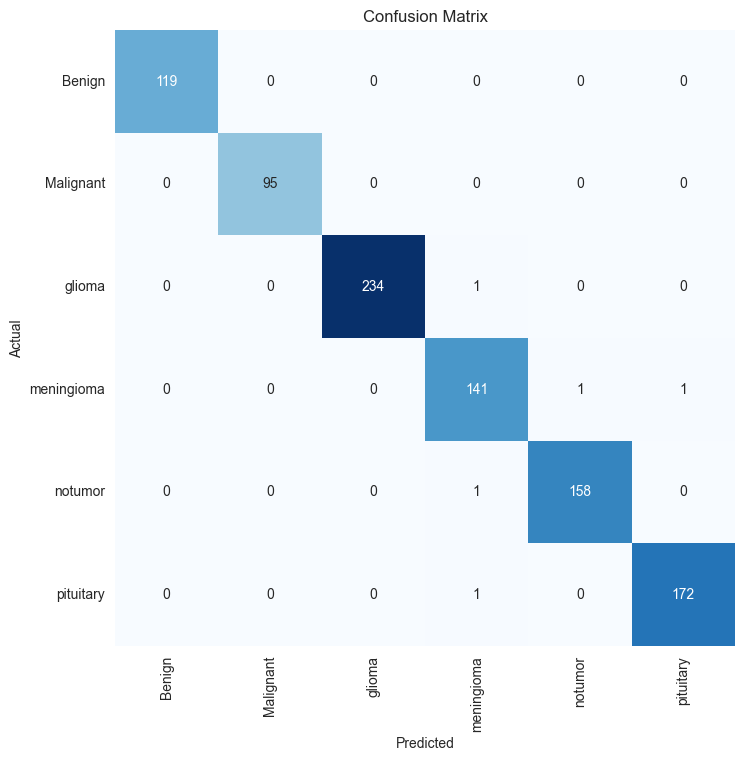

Classification Report:
ــــــــــــــــــــــ
               precision    recall  f1-score   support

      Benign       1.00      1.00      1.00       119
   Malignant       1.00      1.00      1.00        95
      glioma       1.00      1.00      1.00       235
  meningioma       0.98      0.99      0.98       143
     notumor       0.99      0.99      0.99       159
   pituitary       0.99      0.99      0.99       173

    accuracy                           0.99       924
   macro avg       0.99      0.99      0.99       924
weighted avg       0.99      0.99      0.99       924



In [13]:
predictions = model.predict(test_gen)
cm_report(test_gen, predictions)